In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [212]:
def load_eval_dirs(evaluation_folders):
    # Mapping from evaluation name to list of CSV's
    evaluation_data = {}

    # For every folder, go through every evaluation step and load the training CSV
    for eval_folder in evaluation_folders:
        if not os.path.exists(eval_folder):
            raise Exception(f"Path '{eval_folder}' does not exist")
        base_dir = os.path.basename(eval_folder.rstrip("/"))

        evaluation_data[base_dir] = []
        
        eval_step_dirs = [os.path.join(eval_folder, eval_step_dir) for eval_step_dir in os.listdir(eval_folder) if os.path.isdir(os.path.join(eval_folder, eval_step_dir)) and eval_step_dir.startswith("evaluation_step")] 
        eval_step_dirs = sorted(eval_step_dirs, key=lambda dir: int(dir.split("_")[-1]))
        for eval_step in eval_step_dirs:
            with open(os.path.join(eval_step, "runs/detect/train/results.csv"), "r") as file:
                # Skip header, convert everything to a numpy array and store
                data = file.readlines()[1:]
                data = np.array([[float(elem) for elem in row.split(",")] for row in data])

            evaluation_data[base_dir].append(data)
        
        evaluation_data[base_dir] = np.array(evaluation_data[base_dir])

    return evaluation_data

In [213]:
def load_eval_dir(base_eval_dir):
    evaluation_folders = [os.path.join(base_eval_dir, d) for d in os.listdir(base_eval_dir)]

    # Load eval data, then format it so we group together sim, gan and diffusion
    eval_data = load_eval_dirs(evaluation_folders)

    eval_data_by_method = {"diffusion": [], "gan": [], "sim": []}
    for eval in eval_data:
        for method in eval_data_by_method:
            if eval.startswith(method):
                eval_data_by_method[method].append(eval_data[eval])
                break

    # Dict of method with each np array of shape [evaluations, evaluation_step, epoch, csv attributes]
    eval_data_by_method = {k: np.array(v) for k, v in eval_data_by_method.items()}
    return eval_data_by_method

In [214]:
CSV_HEADER = ["epoch", "train/box_loss", "train/cls_loss", "train/dfl_loss", "metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)", "val/box_loss", "val/cls_loss", "val/dfl_loss", "lr/pg0", "lr/pg1", "lr/pg2"]
metrics_of_interest = ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)", "val/box_loss", "val/cls_loss"]

def plot_metrics_of_interest(eval_data_by_method, x_axis):

    fig, axs = plt.subplots(2, 3, figsize=(20, 8))
    epoch = -1

    for index, metric in enumerate(metrics_of_interest):
        index = np.unravel_index(index, (2,3))

        diffusion_metric_mean = np.mean(eval_data_by_method["diffusion"][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
        diffusion_metric_std = np.std(eval_data_by_method["diffusion"][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
        gan_metric_mean = np.mean(eval_data_by_method["gan"][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
        gan_metric_std = np.std(eval_data_by_method["gan"][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
        sim_metric_mean = np.mean(eval_data_by_method["sim"][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
        sim_metric_std = np.std(eval_data_by_method["sim"][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
        
        axs[index[0], index[1]].plot(x_axis, diffusion_metric_mean)
        axs[index[0], index[1]].fill_between(
            x_axis, diffusion_metric_mean - diffusion_metric_std, diffusion_metric_mean + diffusion_metric_std,
            color="blue", alpha=0.1, label="Diffusion"
        )
        axs[index[0], index[1]].plot(x_axis, gan_metric_mean)
        axs[index[0], index[1]].fill_between(
            x_axis, gan_metric_mean - gan_metric_std, gan_metric_mean + gan_metric_std,
            color="orange", alpha=0.1, label="CUT"
        )
        axs[index[0], index[1]].plot(x_axis, sim_metric_mean)
        axs[index[0], index[1]].fill_between(
            x_axis, sim_metric_mean - sim_metric_std, sim_metric_mean + sim_metric_std,
            color="green", alpha=0.1, label="Simulator"
        )
        # plt.title(f"{metric} on FSOCO validation set averaged over 3 evaluations")
        axs[index[0], index[1]].set_xlabel("Number of Synthetic Samples")
        axs[index[0], index[1]].set_ylabel(f"{metric}")
        axs[index[0], index[1]].set_title(f"{metric} as a function of synthetic samples")

    fig.tight_layout() 
    plt.legend()
    plt.show()

FSOCO


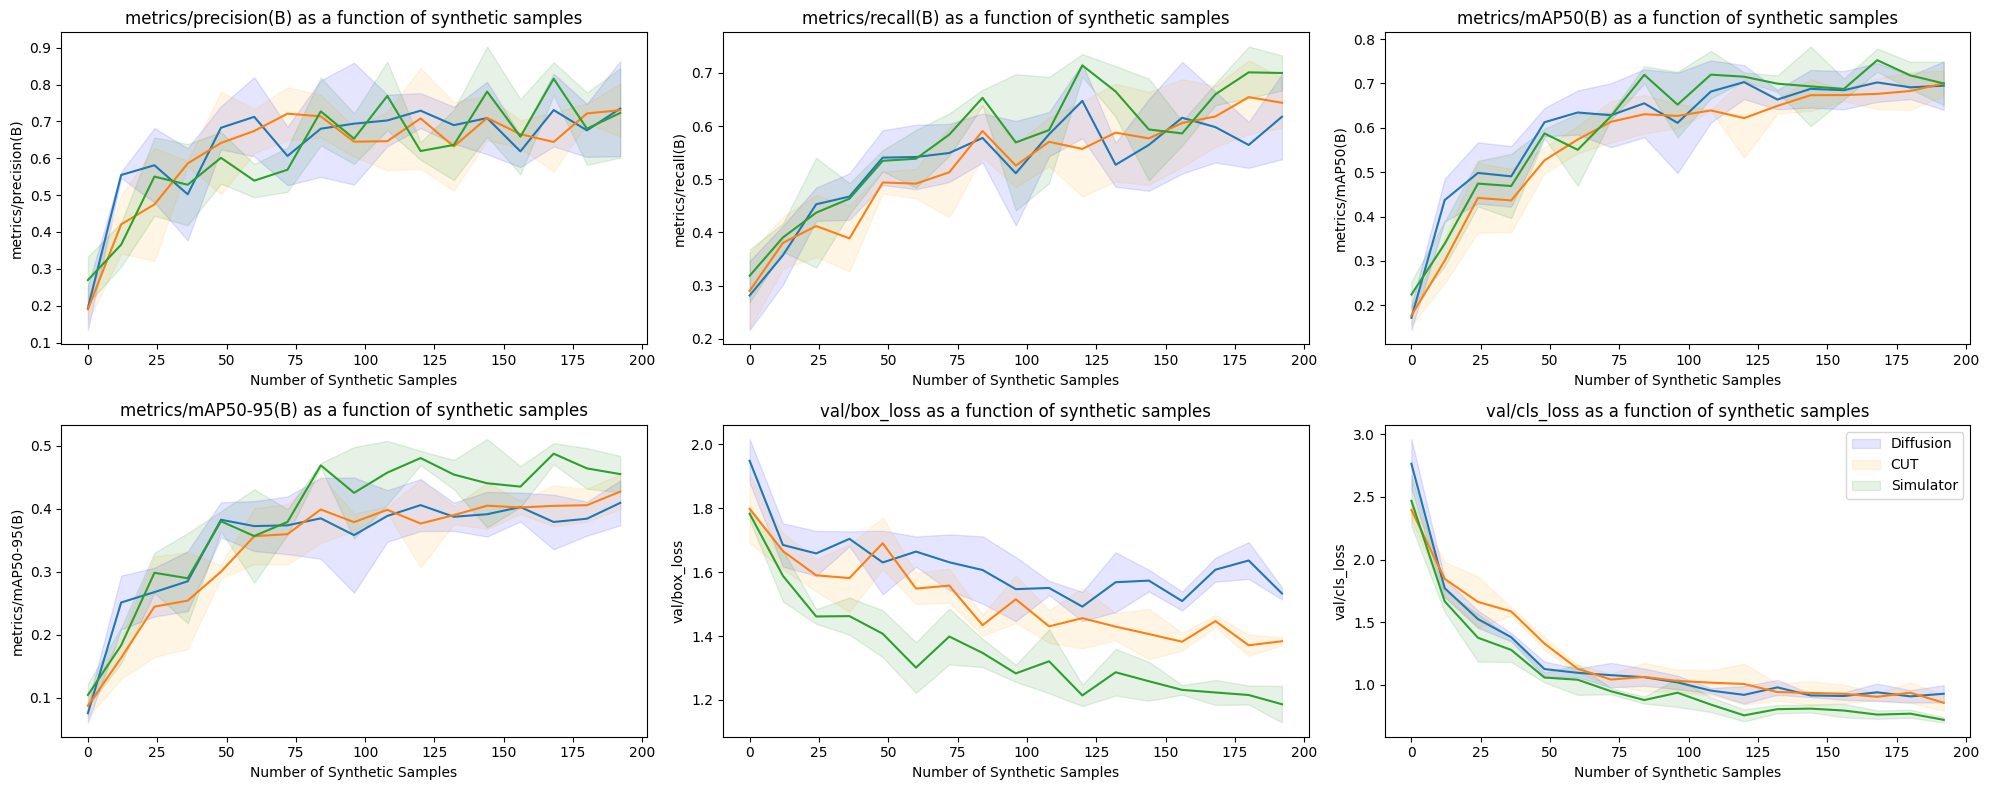

UGR


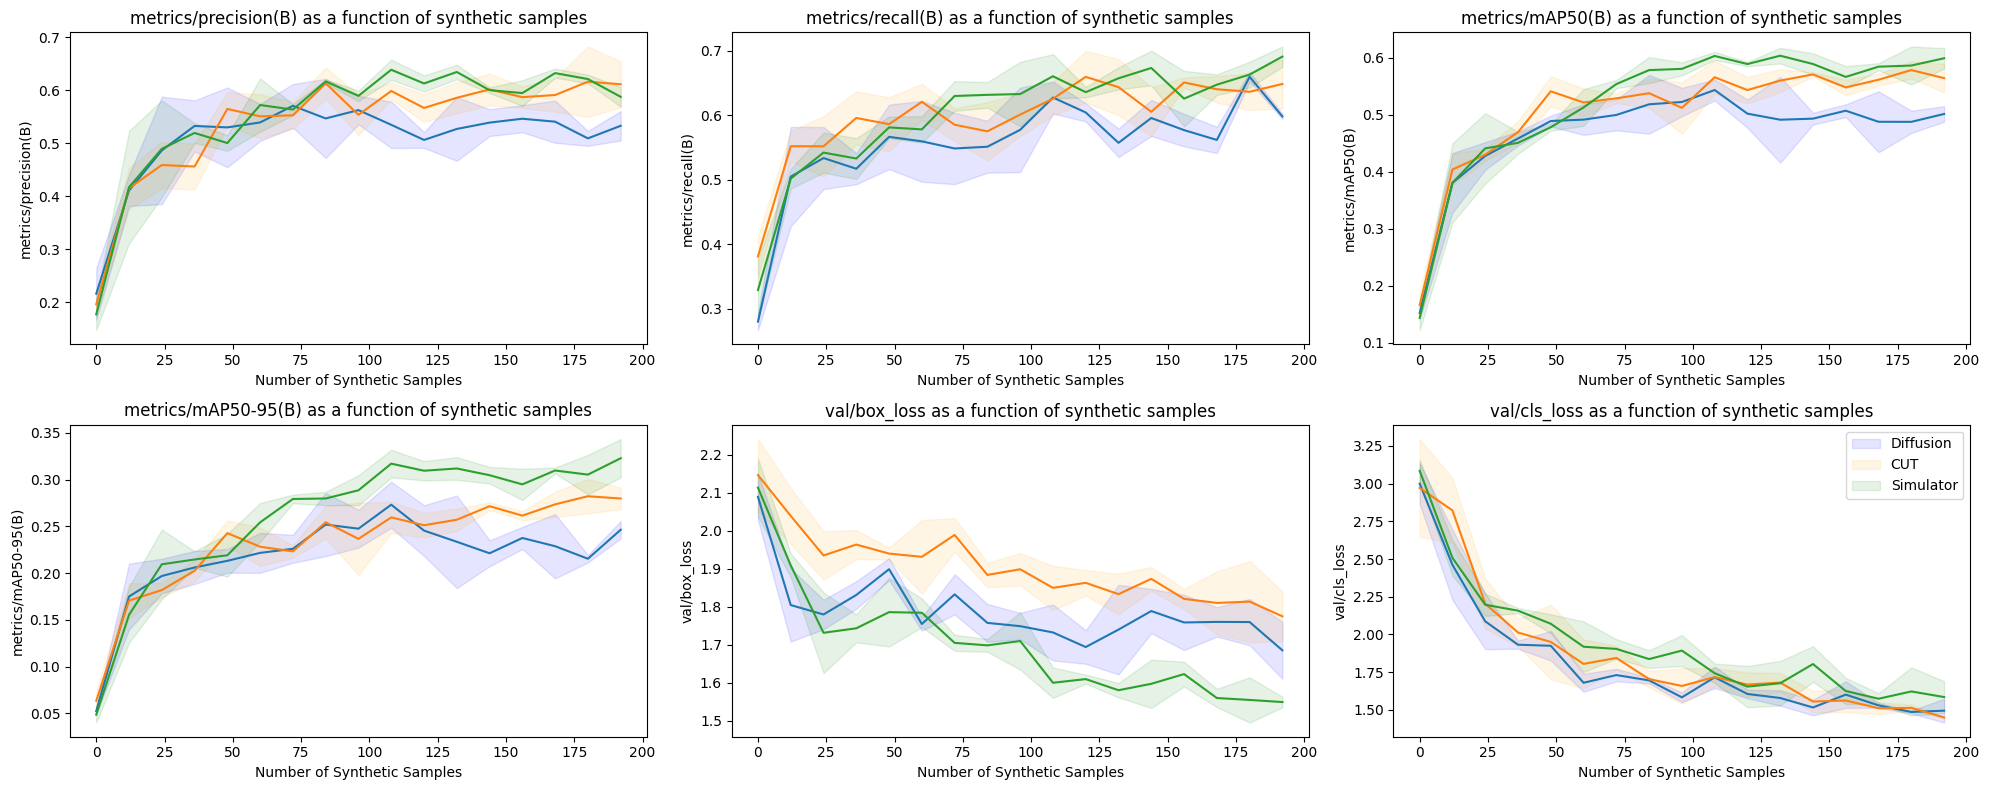

COMBINED


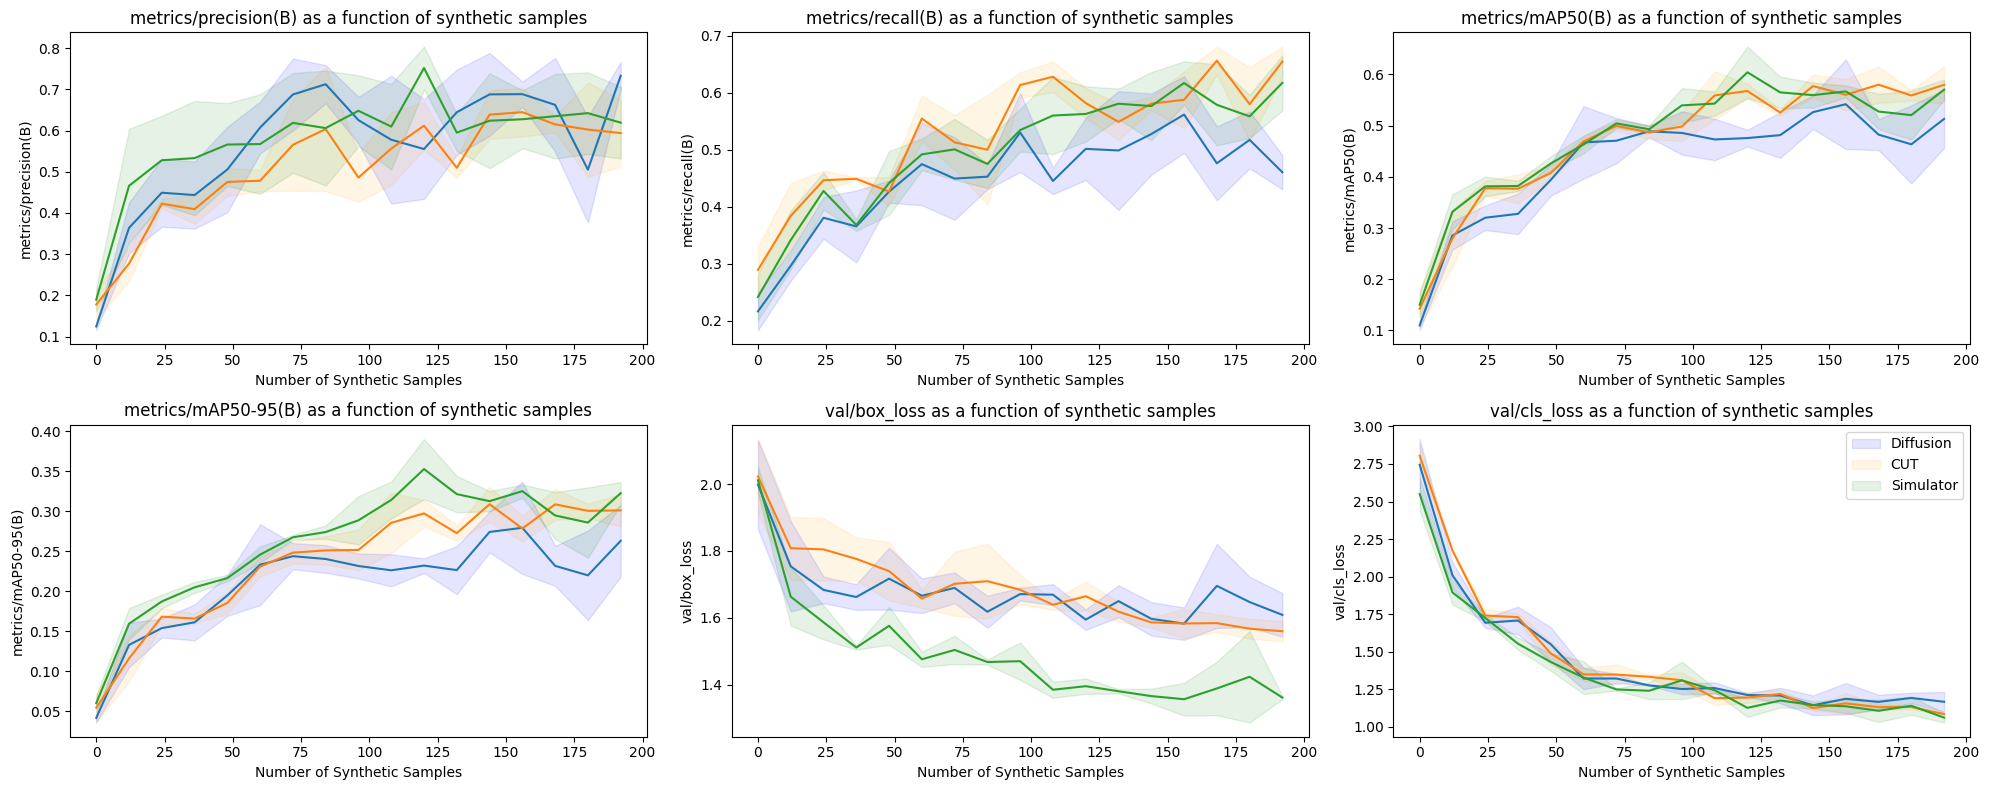

In [215]:
# Supplementing Dataset
old_eval_fsoco = load_eval_dir("/home/aidan/dissertation/old_evaluations/fsoco_validation_runs")
old_eval_ugr = load_eval_dir("/home/aidan/dissertation/old_evaluations/our_validation_runs")
old_eval_combined = load_eval_dir("/home/aidan/dissertation/old_evaluations/combined_validation_runs")

# Evaluations supplementing dataset
x_axis = (np.arange(0, 17)*(25//2))
print("FSOCO")
plot_metrics_of_interest(old_eval_fsoco, x_axis)
print("UGR")
plot_metrics_of_interest(old_eval_ugr, x_axis)
print("COMBINED")
plot_metrics_of_interest(old_eval_combined, x_axis)

# Evaluations with only synthetic data
x_axis = (np.arange(0, 13)*15) + 15
x_axis[-1] = 200

In [216]:
# Graph showing performance for each model across validation sets as a function of synthetic samples
def plot_validation_sets(methods_eval_data, validation_names, method, x_axis):
    print(method)
    colours = ["blue", "orange", "green"]
    fig, axs = plt.subplots(2, 3, figsize=(20, 8))
    epoch = -1

    for metric_idx, metric in enumerate(metrics_of_interest):
        ax_idx = np.unravel_index(metric_idx, (2,3))
        
        for eval_idx, eval_method in enumerate(methods_eval_data):
            metric_mean = np.mean(eval_method[method][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
            metric_std = np.std(eval_method[method][:, :, epoch, CSV_HEADER.index(metric)], axis=0)
            axs[ax_idx[0], ax_idx[1]].plot(x_axis, metric_mean, c=colours[eval_idx])
            axs[ax_idx[0], ax_idx[1]].fill_between(
                x_axis, metric_mean - metric_std, metric_mean + metric_std,
                alpha=0.1, color=colours[eval_idx], label=validation_names[eval_idx]
            )
            axs[ax_idx[0], ax_idx[1]].plot(x_axis, metric_mean)
        
        axs[ax_idx[0], ax_idx[1]].set_xlabel("Number of Synthetic Samples")
        axs[ax_idx[0], ax_idx[1]].set_ylabel(f"{metric}")

    plt.legend()
    fig.tight_layout()
    plt.show()

diffusion


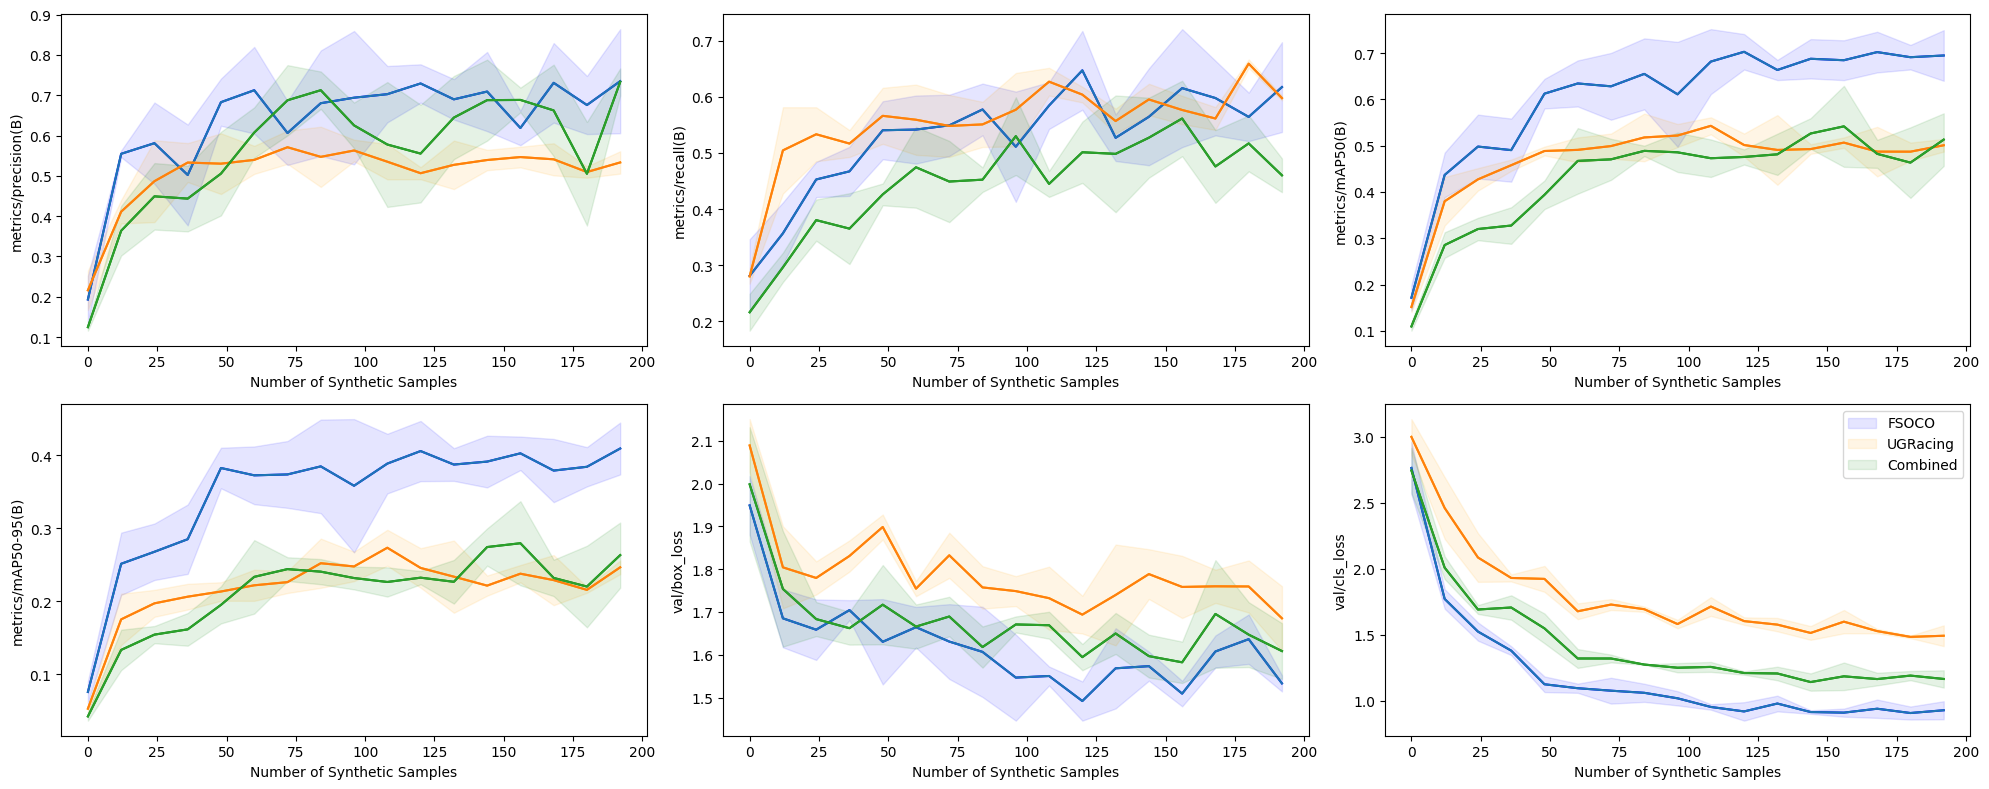

gan


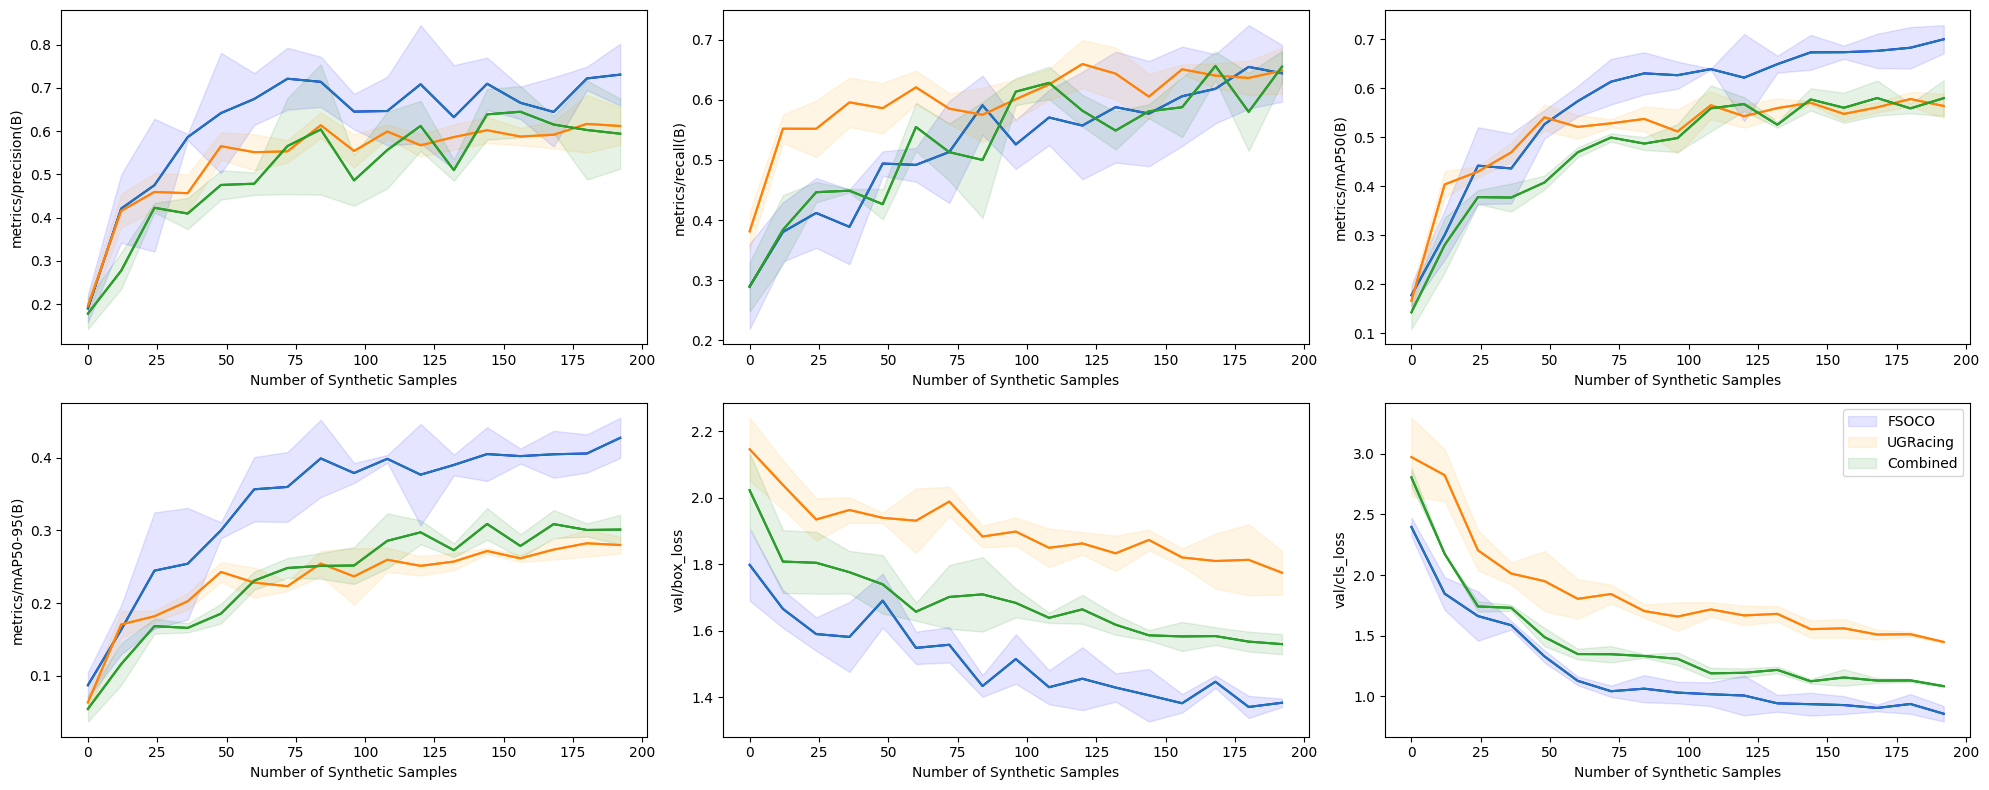

sim


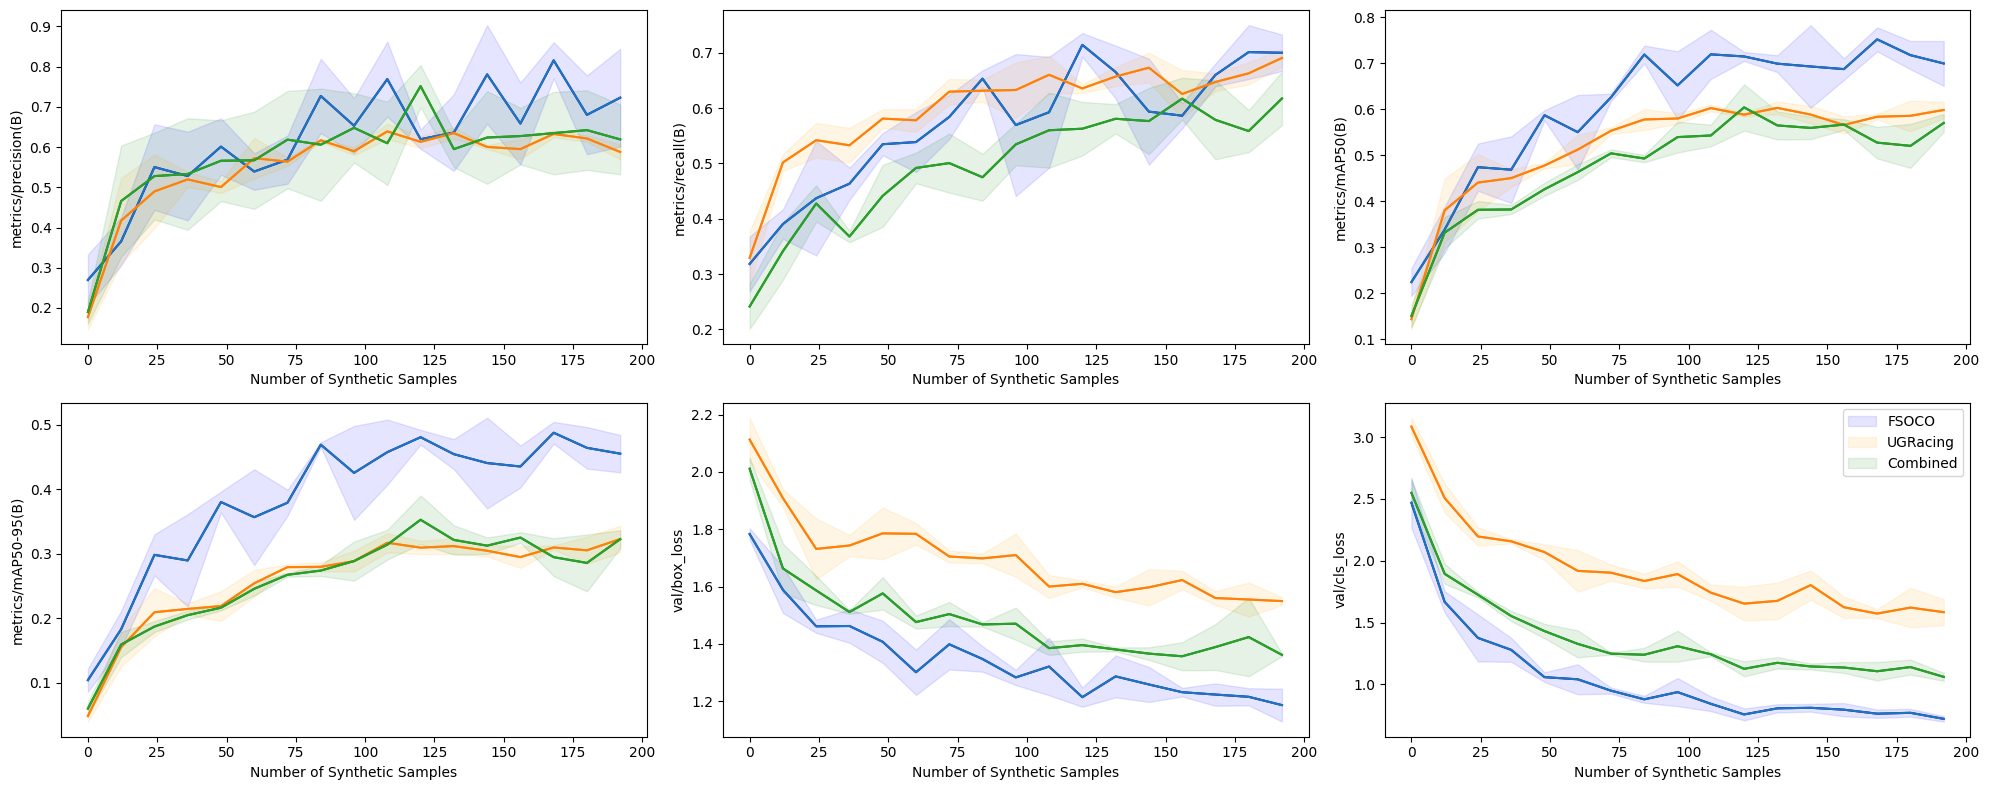

In [217]:
# Supplementing Dataset
x_axis = (np.arange(0, 17)*(25//2))
validation_sets = [old_eval_fsoco, old_eval_ugr, old_eval_combined]
validation_names = ["FSOCO", "UGRacing", "Combined"]
plot_validation_sets(validation_sets, validation_names, "diffusion", x_axis)
plot_validation_sets(validation_sets, validation_names, "gan", x_axis)
plot_validation_sets(validation_sets, validation_names, "sim", x_axis)

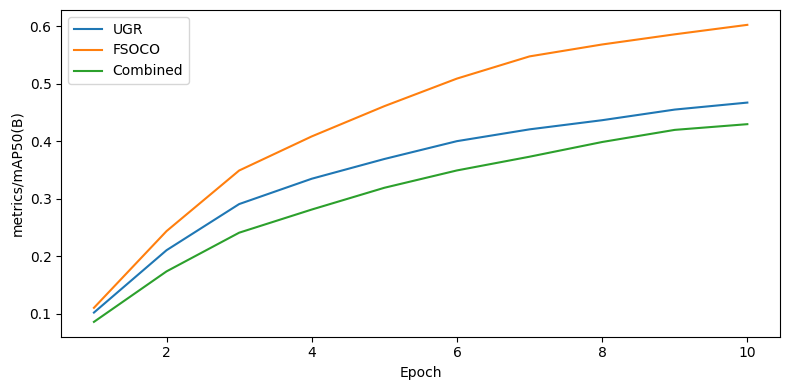

In [218]:
# Show average metrics as a function of epochs for each method

fig, axs = plt.subplots(1, 1, figsize=(20/2.5, 4))
metric = "metrics/mAP50(B)"
for ax_idx, method in enumerate(["diffusion"]):
    for eval_name, eval in zip(["UGR", "FSOCO", "Combined"], [old_eval_ugr, old_eval_fsoco, old_eval_combined]):
        axs.plot(np.arange(1, 11), np.mean(np.mean(eval[method][:, :, :, CSV_HEADER.index(metric)], axis=1), axis=0), label=f"{eval_name}")
        axs.set_xlabel("Epoch")
        axs.set_ylabel(f"{metric}")
        # axs[ax_idx].set_title(f"{metric} as a function of epochs ")

fig.tight_layout()
plt.legend()
plt.show()


In [231]:
# Supplementing Dataset
new_eval_fsoco = load_eval_dir("/home/aidan/dissertation/new_evaluations/fsoco_validation_runs")
new_eval_ugr = load_eval_dir("/home/aidan/dissertation/new_evaluations/our_validation_runs")
new_eval_combined = load_eval_dir("/home/aidan/dissertation/new_evaluations/combined_validation_runs")

# Evaluations with only synthetic data
# x_axis = (np.arange(0, 14)*15) + 15
# x_axis[-1] = 200
# print("FSOCO")
# plot_metrics_of_interest(new_eval_fsoco, x_axis)
# print("UGR")
# plot_metrics_of_interest(new_eval_ugr, x_axis)
# print("COMBINED")
# plot_metrics_of_interest(new_eval_combined, x_axis)

np.mean(old_eval_combined["sim"][:, -1, -1, CSV_HEADER.index("metrics/mAP50(B)")])

0.5704033333333333